# Impacts of Toxic Pollution on Life Expectancy and Cancer Rates for Local Communities

## Introduction to Machine Learning, Final Project Report
## December 15th, 2019
## Cole Smith

------------------------------------------------------------------------------------------------------------

# Problem Overview

Using publicly available data from the EPA and CDC, I would like to explore the potential links of toxic dumping to general life expectancy and cancer rates at the local level, throughout the United States. Specifically, I have the data to do so from 2000 to 2016. Initially, I will constrain this range to 2010 to 2016 to align with
the most recent Census (needed for life expectancy).

It is well known that certain chemicals are a contributing cause to a decline in public health. However, the process of disposing or sequestering these toxics are not equal, and local ecological factors may mean one method is significantly more dangerous for a given region than other methods. 

# Methodology

I have separated my data into three categories: Health (cancer and life expectancy), TRI (the
Toxic Release Inventory), and the AQI (Air Quality Index).  Given these three categories, I
will determine some geo-spatial correlation between their values.
Data is grouped by various regions including state, county, and custom defined regions.  I
will  use  OpenStreetMap’s  Nominatim  API  to  convert  these  regions  to  their  Latitude  and
Longitude.  State level information will be folded into county-level data points, and custom
regions will be handled by changing the precision of the Lat/Lon measurement to integer accuracy, grouping neighboring regions into one. This represents areas roughly 100km wide.

# Data Overview

**Four datasets** are considered for this project from 2010 to 2016. For measures of **Air Quality**, I consider the EPA's **AirData AQI (Air quality index) data set**. For measures of **toxicity**, I consider the EPA's
**Toxics Release Inventory (TRI)** data set, which consists of toxic dumping reports by all companies in a given
area. All companies are required to report their toxic dumping to the EPA.

For measures of **health**, I'm considering the **US Census data**, which gives the life expectancy for different
census tracts, and is valid for the last census of 2010 to 2016. Lastly, for cancer reporting, I am using the
**CDC's WONDER Cancer Database**.

# Package Requirements

    pandas
    scikit-learn
    numpy
    jupyterlab
    matplotlib
    geocoder
    
------------------------------------------------------------------------------------------------------------

# Preparing The Data

Each dataset is prepared individually, and joined on a common index of **lat, lon, year** for each dataset.

## Latitude and Longitude Transformation (Originally in `src/etl/preprocess.py`)

We will first define a function to convert textual queries to latitude and longitude data using OpenStreetMap's
**Nominatim** database. We will have to make a very high number of queries, so this function supports loading
from and writing new queries to an output file. This will be important since we eventually reach a maxiumum
quota, and will need to try again later. 

I provide a file `latlon.json` which includes all the necessary queries
for my datasets. But I originally had to make this myself with the following function.

In [5]:
## Work in the root directory
%cd ..

/home/cole/Desktop/intro-to-ml-final-project


In [6]:
import json

import geocoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler

In [7]:
def make_lat_lon_map(inputs, output_json_file='data/latlon.json', load_from='data/latlon.json'):
    """
    Queries OpenStreetMap for Lat/Lon pairs given a list
    of input queries. The results are incrementally written
    to an output file in `data` by default. Errors are logged
    to a separate file for manual lookup.

    :param inputs:              A list of UNIQUE values to query
    :param output_json_file:    Optional separate JSON output file
    :param load_from:           Resumes from another JSON file
                                entries in the file will not be
                                reprocessed
    :return: `None`
    """
    # {"query": [lat, lon]}
    json_acc = {}

    # Remove duplicates
    inputs = list(set(inputs))

    if load_from:
        with open(load_from, 'r') as json_file:
            json_acc = json.load(json_file)
        inputs = [i for i in inputs if i not in json_acc.keys()]

    def dump(j):
        with open(output_json_file, 'w') as fp:
            json.dump(j, fp, indent=4)

    def dump_errors(e):
        with open("data/nominatim_errors.txt", 'w') as fp:
            for err in e:
                fp.write(err + '\n')

    errors = []
    for query in inputs:
        query = str(query)
        if query not in json_acc:
            g = geocoder.osm(query)

            if not g.ok:
                print("[ WRN ]", query, "--", str(g))
                errors.append(query)
                dump_errors(errors)

            else:
                print("[ MAP ] Found", g.latlng, "for", query)
                json_acc[query] = g.latlng
                dump(json_acc)

## Common Loading (Originally in `src/etl/load.py`)

We will first define a common loading procedure that works for most of the datasets considered here.

In [8]:
import glob
import json
import os
import re

import pandas as pd

In [9]:
# Not required for Notebook, function copied in
# from src.etl.preprocess import make_lat_lon_map

RAW_DATA = 'data/raw/'
PREPARED_DATA = 'data/prepared'

# Load the Lat/Lon Informtion
with open('data/latlon.json', 'r') as fp:
    lat_lon_json = json.load(fp)


def _load(subpath):
    """
    Common loadining method for CSVs in data directory.

    :param subpath:     Subpath in `data`
    :return:            DataFrame
    """
    path = os.path.join(RAW_DATA, subpath, '*.csv')
    all_files = glob.glob(path)

    li = []
    for filename in all_files:
        df = pd.read_csv(filename, index_col=None)
        li.append(df)

    return pd.concat(li, axis=0, ignore_index=True)


def _get_lat_lon(q):
    """
    Returns latitude and longitude pair from generated
    JSON file.

    :param q:   String query
    :return:    Latitude Longitude Pair
    """
    if q in lat_lon_json:
        return lat_lon_json[q]
    else:
        return [None, None]


def _change_precision(a, prec=0):
    """
    Changes the precision of the Latitude
    or Longitude arrays while preserving
    sparsity.

    :param a:       Input array
    :param prec:    New Decimal Precision
    :return:        Rounded array
    """
    acc = []
    for e in a:
        if e is None:
            acc.append(None)
        else:
            acc.append(round(float(e), prec))
    return acc

## TRI

We will begin by preparing the TRI dataset. In order to get this into a common format, we will make the following
transformations:

1. Clean the column names to remove spaces and capitals
2. Select relevant columns (as defined in function)
3. Pivot on `industry` since it is categorical
4. Fix the schema for the columns which will become the index (lat, lon, year)
5. Change precision of lat and lon
6. Regroup by year, lat, lon and aggregate by **sum**

The TRI dataset is fortunate enough to not require lat, lon conversion. It comes with lat lon already.

In [ ]:
def load_tri():
    """
    Loads the TRI CSV files into one DataFame

    :return: DataFrame
    """
    # Remove NA columns
    combined = _load('tri')

    # Clean column names
    cols = combined.columns
    cols = [c.split(' - ')[-1] for c in cols]
    cols = [c.split('. ')[-1].lower() for c in cols]
    combined.columns = cols
    combined = combined.rename(columns={'production wste (8.1-8.7)': 'production waste',
                                        'latitude': 'lat', 'longitude': 'lon'})

    # Select Relevant
    sel = ['year', 'lat', 'lon', 'industry sector',
           'fugitive air', 'stack air', 'water', 'underground',
           'underground cl i', 'underground c ii-v', 'landfills',
           'rcra c landfill', 'other landfills', 'land treatment',
           'surface impndmnt', 'rcra surface im', 'other surface i',
           'on-site release total', 'trns rlse', 'trns trt',
           'total transfers', 'm10', 'm41', 'm62', 'm40 metal', 'm61 metal', 'm71',
           'm81', 'm82', 'm72', 'm63', 'm66', 'm67', 'm64', 'm65', 'm73', 'm79',
           'm90', 'm94', 'm99', 'off-site release total', 'm20', 'm24', 'm26',
           'm28', 'm93', 'off-site recycled total', 'm56', 'm92',
           'm40 non-metal', 'm50', 'm54',
           'm61 non-metal', 'm69', 'm95', 'off-site treated total',
           'total transfer', 'total releases', 'releases', 'on-site contained',
           'off-site contain', 'production waste']

    combined = combined[sel].dropna(axis=1)
    combined.columns = [c.replace(' ', '_') for c in combined.columns]

    # Pivot industry
    d = pd.get_dummies(combined['industry_sector'], prefix='sector')
    df = pd.concat([combined, d], axis=1).drop(['industry_sector'], axis=1)

    # Fix schema
    df = df.dropna()
    df.year = df.year.astype(int)
    df.lat = df.lat.astype(int)
    df.lon = df.lon.astype(int)

    # Shift Precision
    df.lat = _change_precision(df.lat)
    df.lon = _change_precision(df.lon)

    # Group up
    df = df.dropna().groupby(by=['year', 'lat', 'lon'], as_index=False).sum()

    return df.dropna()

## AQI

We will begin by preparing the AQI dataset. In order to get this into a common format, we will make the following
transformations:

1. Clean the column names to remove spaces and capitals
2. Select relevant columns (as defined in function)
3. Convert date to `year` by remove the month and day
4. Pivot on `defining_parameter` since it is categorical. This column denotes the worst factor for air quality that day
5. Regroup by `'year', 'state_name', 'county_name'`, aggregating by `mean`.
6. Convert `'state_name', 'county_name'` to `lat` and `lon` using the JSON file.
7. Fix the schema for the columns which will become the index (lat, lon, year)
8. Change precision of lat and lon
9. Regroup by year, lat, lon and aggregate by **sum**

In [ ]:
def load_aqi():
    """
    Loads the AQI CSV files into one DataFame

    :return: DataFrame
    """
    # Remove NA columns
    combined = _load('aqi').dropna(axis=1)

    # Select relevant columns
    sel = ['State Name', 'county Name', 'Date', 'AQI', 'Defining Parameter']
    combined = combined[sel]

    # Clean column names
    combined.columns = [c.replace(" ", "_").lower() for c in combined.columns]

    # Convert date column to year only
    combined.date = combined.date.str.split('-').str[0]
    combined = combined.rename(columns={'date': 'year'})
    combined = combined.astype({'year': 'int64'})

    # Pivot defining_parameter column
    d = pd.get_dummies(combined['defining_parameter'], prefix='defining')
    df = pd.concat([combined, d], axis=1).drop(['defining_parameter'], axis=1)
    df = df.dropna().groupby(by=['year', 'state_name', 'county_name'], as_index=False).mean()

    # Convert to Lat/Lon
    loc = list(df.state_name + ", " + df.county_name)
    make_lat_lon_map(list(set(loc)))

    lat = [_get_lat_lon(i)[0] for i in loc]
    lon = [_get_lat_lon(i)[1] for i in loc]

    df['lat'] = _change_precision(lat)
    df['lon'] = _change_precision(lon)

    # Fix Schema
    df = df.dropna()
    df.year = df.year.astype(int)
    df.lat = df.lat.astype(int)
    df.lon = df.lon.astype(int)

    # Group up
    df = df.dropna().groupby(by=['year', 'lat', 'lon'], as_index=False).sum()

    return df.dropna()

## Cancer

We will begin by preparing the Cancer dataset. In order to get this into a common format, we will make the following
transformations:

1. Clean the column names to remove spaces and capitals
2. Select relevant columns (as defined in function)
3. Pivot on `leading_cancer_sites` since it is categorical.
4. Fix the `MSA` column by defining a custom transformation policy for use in querying with **Nominatum**. This is required since the MSA regions sometimes include metropolitan area spanning across state lines for which Nominatim isn't able to handle.
5. Convert the cleaned `MSA` column to `lat` and `lon`.
6. Fix the schema for the columns which will become the index (lat, lon, year)
7. Change precision of lat and lon
8. Regroup by year, lat, lon and aggregate by **sum**

In [ ]:
def load_cancer():
    path = os.path.join(RAW_DATA, "health/United States and Puerto Rico Cancer Statistics, 1999-2016 Incidence.txt")
    cancer = pd.read_csv(path, delimiter='\t')

    # Select relevant columns
    sel = ['Year', 'Leading Cancer Sites', 'MSA', 'Count', 'Population', 'Age-Adjusted Rate']
    cancer = cancer[sel]
    cancer.columns = [c.replace(' ', '_').lower() for c in cancer.columns]

    # Pivot criteria
    d = pd.get_dummies(cancer['leading_cancer_sites'], prefix='cancer')
    d = d.multiply(cancer['count'], axis="index")
    cancer = pd.concat([cancer, d], axis=1).drop(['leading_cancer_sites', 'count'], axis=1)

    # Fix MSA
    tmp = cancer.msa
    ntmp = []

    # Also load manual map
    manual = {}
    with open('data/cancer_manual_map.txt', 'r') as fp:
        for l in fp:
            items = l.split('|')
            manual[items[0].strip()] = items[1].strip()

    # MSA Conversion Policy
    for t in tmp:
        t = str(t)
        t = t.replace('-', ' ')
        if len(re.split(',|,,', t)) == 1:
            ntmp.append(t)
            continue

        states = re.split(',|,,', t)[1]
        state = states.split()[0]

        areas = t.split()
        if len(areas) > 1:
            area = t.split()[0] + ' ' + t.split()[1]
        else:
            area = areas[0]

        tt = area + ", " + state

        if tt in manual:
            ntmp.append(manual[tt])
        else:
            ntmp.append(tt)

    cancer.msa = ntmp
    cancer = cancer.dropna()

    # Convert to Lat/Lon
    loc = list(cancer.msa)
    make_lat_lon_map(list(set(loc)))

    lat = [_get_lat_lon(i)[0] for i in loc]
    lon = [_get_lat_lon(i)[1] for i in loc]

    cancer['lat'] = _change_precision(lat, prec=0)
    cancer['lon'] = _change_precision(lon, prec=0)

    # Fix Schema
    cancer = cancer.dropna()
    cancer.year = cancer.year.astype(int)
    cancer.lat = cancer.lat.astype(int)
    cancer.lon = cancer.lon.astype(int)

    # Group up
    cancer = cancer.dropna().groupby(by=['year', 'lat', 'lon'], as_index=False).sum()

    return cancer.dropna()

## Life Expectancy

We will begin by preparing the Life Expectancy dataset. In order to get this into a common format, we will make the following
transformations:

1. Clean the column names to remove spaces and capitals
2. Select relevant columns (as defined in function)
3. Fix the Life Exp range to Min and Max values, which could potentially be good features.
4. Group by state and county, aggregate by mean to get the average life exp for that state and county
5. Convert state and county to `lat` and `lon` using the JSON file
6. Fix the schema for the columns which will become the index (lat, lon, year)
7. Change precision of lat and lon
8. Regroup by year, lat, lon and aggregate by **sum**

In [10]:
def load_life_exp():
    path = os.path.join(RAW_DATA, 'health', 'U.S._Life_Expectancy_at_Birth_by_State_and_Census_Tract_-_2010-2015.csv')
    life = pd.read_csv(path)

    # Select Relevant
    sel = ['State', 'County', 'Life Expectancy',
           'Life Expectancy Range']
    life = life[sel].dropna()

    # Fix column names
    life.columns = [c.replace(' ', '_').lower() for c in life.columns]

    # Fix Life Exp Range to Min and Max
    rng = list(life.life_expectancy_range)
    rng_max = [float(str(r).split('-')[1].strip()) for r in rng]
    rng_min = [float(str(r).split('-')[0].strip()) for r in rng]

    life['life_expectancy_max'] = rng_max
    life['life_expectancy_min'] = rng_min
    life = life.rename(columns={'life_expectancy': 'life_expectancy_avg'})
    life = life.drop('life_expectancy_range', axis=1).dropna()

    life = life.groupby(['state', 'county'], as_index=False).mean()

    # Convert to Lat/Lon
    print("Getting lat lon list")
    loc = list(life.state + ", " + life.county)
    make_lat_lon_map(list(set(loc)))

    lat = [_get_lat_lon(i)[0] for i in loc]
    lon = [_get_lat_lon(i)[1] for i in loc]

    life['lat'] = _change_precision(lat, prec=0)
    life['lon'] = _change_precision(lon, prec=0)

    # Fix Schema
    life = life.dropna()
    life.lat = life.lat.astype(int)
    life.lon = life.lon.astype(int)

    # Group up
    life = life.dropna().groupby(by=['lat', 'lon'], as_index=False).sum()

    return life.dropna()

## Load All

Combine the datasets by **year, lat, and lon**. This is then written to a file that will constitute our **main dataset**.

In [12]:
def load_all(from_file=True):
    if from_file:
        return pd.read_csv('data/merged.csv')

    print("[ LOAD ] Loading AQI...")
    aqi = load_aqi()
    print(aqi)

    print("[ LOAD ] Loading TRI...")
    tri = load_tri()
    print(tri)

    print("[ LOAD ] Loading Life...")
    life = load_life_exp()
    print(life)

    print("[ LOAD ] Loading Cancer...")
    cancer = load_cancer()
    print(cancer)

    # Join
    j = aqi.merge(tri, on=['year', 'lat', 'lon'], how='inner')
    j = j.merge(cancer, on=['year', 'lat', 'lon'], how='inner')
    j = j.merge(life, on=['lat', 'lon'], how='left')
    j = j.dropna()

    # TODO: Fix weird behavior with duplicated rows in merge that make this line necessary
    j = j.groupby(by=['year', 'lat', 'lon'], as_index=False).mean()

    j.to_csv('data/merged.csv', index=False)
    return j

In [15]:
df = load_all(from_file=True)
df

,year,lat,lon,aqi,defining_CO,defining_NO2,defining_Ozone,defining_PM10,defining_PM2.5,defining_SO2,...,cancer_Oral Cavity and Pharynx,cancer_Ovary,cancer_Pancreas,cancer_Prostate,cancer_Stomach,cancer_Thyroid,"cancer_Urinary Bladder, invasive and in situ",life_expectancy_avg,life_expectancy_max,life_expectancy_min
0,2010,21,-158,39.715068,0.000000,0.00274,0.230137,0.024658,0.742466,0.000000,...,121.0,64.0,164.0,556.0,115.0,157.0,158.0,81.294118,88.416667,78.852941
1,2010,26,-98,44.077348,0.000000,0.00000,0.406077,0.002762,0.591160,0.000000,...,31.0,40.0,47.0,220.0,44.0,73.0,63.0,159.097706,168.700229,155.627752
2,2010,27,-82,42.367123,0.000000,0.00000,0.695890,0.010959,0.293151,0.000000,...,1023.0,552.0,1137.0,5460.0,598.0,970.0,1947.0,395.213735,412.286007,379.924932
3,2010,28,-82,183.767123,0.000000,0.00000,3.038356,0.002740,0.821918,0.136986,...,134.0,60.0,115.0,554.0,44.0,58.0,182.0,310.118286,323.254386,288.395522
4,2010,28,-81,208.062127,0.000000,0.00000,3.714128,0.000000,1.285872,0.000000,...,405.0,181.0,338.0,1922.0,195.0,301.0,649.0,236.124946,246.422004,226.526906
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581,2016,43,-74,104.521436,0.000000,0.00000,1.748634,0.000000,1.251366,0.000000,...,181.0,62.0,189.0,636.0,82.0,176.0,313.0,559.834455,593.776980,538.773022
582,2016,44,-116,34.267218,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,...,102.0,34.0,105.0,396.0,38.0,119.0,167.0,159.066667,176.233333,158.300000
583,2016,45,-123,30.764543,0.000000,0.00000,0.407202,0.000000,0.592798,0.000000,...,348.0,130.0,339.0,1171.0,141.0,391.0,494.0,238.184173,250.543362,230.657820
584,2016,47,-122,103.114754,0.000000,0.31694,0.989071,0.000000,1.693989,0.000000,...,540.0,219.0,512.0,2089.0,253.0,582.0,857.0,238.026852,248.482308,228.187973


# High Level Statistics

Let us view some high level statistics about our dataset. Namely, we should look at the:

1. Number of Rows
2. Number of Columns
3. Columns with Highest Variance
4. Columns with Lowest Variance
5. Some basic correlations

In [52]:
print("Number of Rows:", len(df))
print("Number of Cols:", len(df.columns), '\n')

print("Highest Variance Cols:")
print(df.var().sort_values(ascending=False)[:10], '\n')

print("Lowest Variance Cols:")
print(df.var().sort_values()[:10], '\n')

print("Top 20 Correlations to Age-Adjusted Rate:")
print(df[[c for c in df.columns if 'cancer' not in c]]
      .corr()['age-adjusted_rate'].sort_values(ascending=False)[:20])

Number of Rows: 586
Number of Cols: 125 

Highest Variance Cols:
population                 3.779196e+15
production_waste           2.542578e+11
total_releases             1.909209e+10
on-site_release_total      1.894071e+10
other_surface_i            5.614605e+09
total_transfer             1.802190e+09
off-site_recycled_total    1.550502e+09
m24                        1.442020e+09
water                      2.049389e+08
off-site_release_total     1.271601e+08
dtype: float64 

Lowest Variance Cols:
releases              0.000000e+00
landfills             0.000000e+00
underground           0.000000e+00
m63                   0.000000e+00
m71                   0.000000e+00
surface_impndmnt      0.000000e+00
sector_Publishing     3.180443e-07
sector_Apparel        6.450643e-07
sector_Coal Mining    2.369974e-05
sector_Tobacco        5.922906e-05
dtype: float64 

Top 20 Correlations to Age-Adjusted Rate:
age-adjusted_rate                     1.000000
population                            0.

## Interpretation

From above, we can see that there are no columns in our desgin matrix that are immediately strongly correlated
with the Age-Adjusted Rate of cancer levels for a given year and area.

This was expected however. Efforts to relate toxic dumping with cancer rates has been historicall inconclusive as evidenced by the following paper survey.

------------------------------------------------------------------------------------------------

### Hazardous waste and health impact:  a systematic review of the scientific literature
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5637250/

In this survey study, the authors assessed 57 papers on the health impacts of toxic waste. The
overall results from many studies were inconclusive – There are many confounding factors
which contribute to cancer rates among individuals.  However, they found that oil industry
waste to be the most hazardous of the types considered in the survey.  This study is fairly
recent, published in 2017, but again considers a traditional sample of selected communities,
instead of a national survey.

------------------------------------------------------------------------------------------------------

# Visualization (Originally `src/model/cluster.py`)

We can now view the prepared datasets individally and together to assess potential clusters, and to help select our model later on. 

We will use a 2-component **PCA Decomposition** on the fully prepared dataset. Let us define a generalized visualization function. 

In [13]:
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

In [14]:
def view_pca(df, emphasize_column=None, title=None, xlabel=None, ylabel=None):
    """
    Charts the 2-component PCA decomposition of
    the given DataFrame, with optional
    coloring upon a separate column. This
    column will NOT be part of the PCA decomposition.

    :param df:                  DataFrame to decompose
    :param emphasize_column:    Column for coloring PCA
    :param title:               Title of Plot
    :param xlabel:              X axis label
    :param ylabel:              Y axis label
    :return:                    `None`
    """
    c = None
    if emphasize_column:
        c = df[emphasize_column]
        df = df.drop(emphasize_column, 1)

    pca = PCA().fit_transform(df)
    plt.scatter(pca[:, 0], pca[:, 1], c=c)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

## Defining our `Y` columns

In order to have a meaningful clustering example, we need to define our `Y` columns and remove them from the DataFrame before the PCA decomposition. The following function will **officially define the columns of our Y set**.

In [53]:
def _in_terms(t):
    y_terms = ['age-adjusted_rate', 'count', 'cancer', 'population', 'life_expectancy']
    for ty in y_terms:
        if ty in t:
            return True
    return False

y_cols = [c for c in df.columns if _in_terms(c)]
x_cols = [c for c in df.columns if c not in y_cols]

## All Merged Data w. EMA, Colored by Age-Adjusted Cancer Rates

Visualize the initial clusters of age-adjusted cancer
rates for each area. We will group each area
by adding up all the years observed.

In [65]:
# Sum over all years
grouped = df.groupby(by=['lat', 'lon']).sum()
drop_cols = [y for y in y_cols if y != 'age-adjusted_rate']

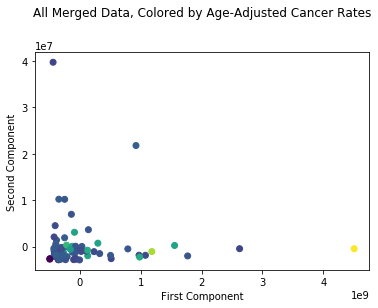

In [73]:
view_pca(grouped.drop(drop_cols, 1), 'age-adjusted_rate',
         title="All Merged Data, Colored by Age-Adjusted Cancer Rates\n\n",
         xlabel="First Component",
         ylabel="Second Component")

We can immediately see some outliers, but let's take a look at some specific featuers as they relate to the age adjusted rate

## Age Adjusted Rate vs AQI (Colored: Age Adjusted Rate)

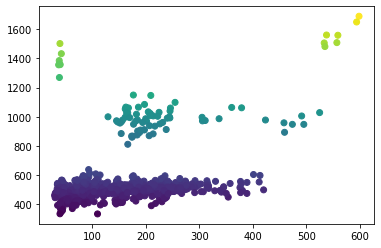

In [61]:
plt.scatter(df['aqi'], df['age-adjusted_rate'], c=df['age-adjusted_rate'])

This looks really good. We can tell the realtionship isn't linear, but there does exist defined clusters which pcoket nicely with the age adjusted rate!

## Age Adjusted Rate vs Number of Dumpings by Petroleum Companies (Colored: Age Adjusted Rate)

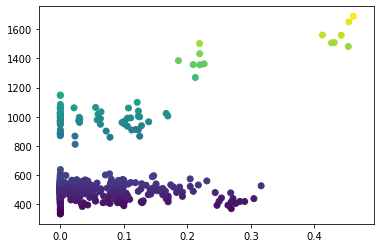

In [64]:
plt.scatter(df['sector_Petroleum Bulk Terminals'], df['age-adjusted_rate'], c=df['age-adjusted_rate'])

This one is also pretty good. We notice again that there are clusters of high-count of dumping from Petroleum Companies,
with high cancer rates as well.

------------------------------------------------------------------------------------------------------

# Feature Engineering (Originally `src/model/features.py`)

After our data is loaded into a single Pandas DataFrame, we now engineer some features that might be helpful. One such feature is the **exponential moving average** for each feature column. I do this to model the time-weighted importance of each factor which may contribute to life expectancy and cancer rates, with the assumption that **areas will consistently high levels of air pollution and toxic dumping exhibit higher rates and lower life expectancy than areas which have a higher recent spike in air pollution and toxic dumping**. The EMA will capture this sentiment using one, two, and three year lags.

Each feature will become a separate EMA column, denoted by `_emaX` where `X` is either `1, 2, or 3`.

In [67]:
def sma_featurizer(df, by=None, lags=None, ema=True):
    """
    Computes the SMA of each column, grouped by
    the `by` set. This follows for each `i` in
    `lags`. The default `by` is `[lat, lon]`. The
    default `lags` is `[1,2,3]`, which represent years
    in the merged dataset in this project. SMA
    columns will be appended with prefix smaN_.

    :param df:      DataFrame to featurize
    :param by:      Grouping columns (default: [lat, lon]
    :param lags:    SMA i periods (default: [1,2,3])
    :param ema:     Use exponential moving averages
    :return:        Featurized DataFrame
    """
    # Resolve defaults
    if by is None:
        by = ['lat', 'lon']
    if lags is None:
        lags = [1, 2, 3]

    # Re-index DataFrame to by columns plus year
    df = df.set_index(by + ['year'])

    # Group by without year to compute SMA/EMA
    g = df.groupby(by=by)

    # Define an inner convenience function
    def roll(i):

        # Apply the SMA/EMA to the inner groupings, which should
        # contain "year"
        if ema:
            r = g.apply(lambda x: x.sort_values(by='year').ewm(i).mean())
            r.columns = ["ema" + str(i) + "_" + c for c in r.columns]
        else:
            r = g.apply(lambda x: x.sort_values(by='year').expanding(i).mean())
            r.columns = ["sma" + str(i) + "_" + c for c in r.columns]
        return r

    # Compute for all lags
    features = roll(lags[0])
    for lag in lags[1:]:
        tmp = roll(lag)

        # Join on by plus year, since year is also still in index
        features = features.join(tmp, how='inner')

    # Join on the original DataFrame, sort, return
    return df.join(features, how='inner').sort_index()

## Featurize our DataFrame

In [68]:
df_ema = sma_featurizer(df, ema=True).dropna()
df_ema

aqi  defining_CO  defining_NO2  defining_Ozone  \
lat lon  year                                                          
21  -158 2010   39.715068     0.000000      0.002740        0.230137   
         2011   39.260274     0.000000      0.000000        0.356164   
         2012   34.628415     0.000000      0.000000        0.352459   
         2013   32.632877     0.000000      0.000000        0.386301   
         2014   29.901961     0.000000      0.002801        0.641457   
...                   ...          ...           ...             ...   
48  -117 2012   51.567907     0.005464      0.000000        0.341530   
         2013   56.944754     0.008219      0.000000        0.372603   
         2014   49.402620     0.016438      0.000000        0.326027   
         2015  109.913899     0.000000      0.000000        0.349862   
         2016   85.160502     0.002732      0.000000        0.352459   

               defining_PM10  defining_PM2.5  defining_SO2  fugitive_air  \
lat lon  year                                                              
21  -158 2010       0.024658        0.742466      0.000000   2583.912486   
         2011       0.016438        0.624658      0.002740   1370.121445   
         2012       0.013661        0.628415      0.005464   2236.499064   
         2013       0.008219        0.605479      0.000000   2309.227402   
         2014       0.044818        0.299720      0.011204   2477.977827   
...                      ...             ...           ...           ...   
48  -117 2012       1.010929        0.642077      0.000000   8352.375000   
         2013       1.024658        0.594521      0.000000   9636.000000   
         2014       1.147945        0.509589      0.000000   5589.983636   
         2015       0.414061        2.236077      0.000000   3703.352857   
         2016       0.169399        2.475410      0.000000   4769.415714   

                  stack_air         water  ...  \
lat lon  year                              ...   
21  -158 2010  11144.868598    607.246914  ...   
         2011  12428.032931    187.125287  ...   
         2012  12623.891313    419.273256  ...   
         2013  11367.313362    454.754118  ...   
         2014  10429.603340    397.932946  ...   
...                     ...           ...  ...   
48  -117 2012   1787.922500  44046.075000  ...   
         2013   1883.042857  26824.700000  ...   
         2014   1047.489091  21748.238182  ...   
         2015   1075.722143  13966.079286  ...   
         2016   1543.432143  15472.586429  ...   

               ema3_cancer_Oral Cavity and Pharynx  ema3_cancer_Ovary  \
lat lon  year                                                           
21  -158 2010                           121.000000          64.000000   
         2011                           109.000000          54.857143   
         2012                           121.540541          51.891892   
         2013                           131.948571          54.857143   
         2014                           139.832266          57.526248   
...                                            ...                ...   
48  -117 2012                            73.540541          39.135135   
         2013                            75.171429          42.011429   
         2014                            75.443022          44.302177   
         2015                            69.529849          42.385506   
         2016                            67.357399          40.254702   

               ema3_cancer_Pancreas  ema3_cancer_Prostate  \
lat lon  year                                               
21  -158 2010            164.000000            556.000000   
         2011            157.714286            589.714286   
         2012            169.945946            554.810811   
         2013            171.428571            536.960000   
         2014            168.010243            534.023047   
...                             ...                   ...   
48  -11

In [69]:
print("Number of Rows:", len(df_ema))
print("Number of Cols:", len(df_ema.columns), '\n')

print("Highest Variance Cols:")
print(df_ema.var().sort_values(ascending=False)[:10], '\n')

print("Lowest Variance Cols:")
print(df_ema.var().sort_values()[:10], '\n')

print("Top 20 Correlations to Age-Adjusted Rate:")
print(df_ema[[c for c in df_ema.columns if 'cancer' not in c]]
      .corr()['age-adjusted_rate'].sort_values(ascending=False)[:20])

Number of Rows: 586
Number of Cols: 488 

Highest Variance Cols:
population               3.779196e+15
ema1_population          3.742045e+15
ema2_population          3.724200e+15
ema3_population          3.714826e+15
production_waste         2.542578e+11
ema1_production_waste    1.859462e+11
ema2_production_waste    1.587683e+11
ema3_production_waste    1.465370e+11
total_releases           1.909209e+10
on-site_release_total    1.894071e+10
dtype: float64 

Lowest Variance Cols:
surface_impndmnt         0.0
ema3_surface_impndmnt    0.0
ema3_underground         0.0
releases                 0.0
ema3_m71                 0.0
m71                      0.0
m63                      0.0
ema1_releases            0.0
ema1_underground         0.0
ema2_releases            0.0
dtype: float64 

Top 20 Correlations to Age-Adjusted Rate:
age-adjusted_rate         1.000000
ema1_age-adjusted_rate    0.998972
ema2_age-adjusted_rate    0.998260
ema3_age-adjusted_rate    0.997837
ema3_population           0

In [70]:
y_cols = [c for c in df.columns if _in_terms(c)]
x_cols = [c for c in df.columns if c not in y_cols]

In [71]:
# Sum over all years
grouped = df_ema.groupby(by=['lat', 'lon']).sum()
drop_cols = [y for y in y_cols if y != 'age-adjusted_rate']

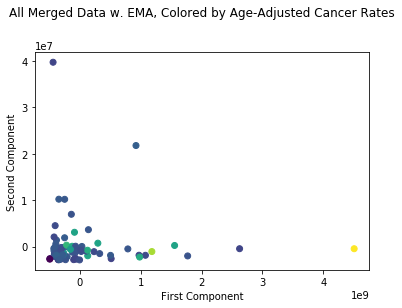

In [72]:
view_pca(grouped.drop(drop_cols, 1), 'age-adjusted_rate',
         title="All Merged Data w. EMA, Colored by Age-Adjusted Cancer Rates\n\n",
         xlabel="First Component",
         ylabel="Second Component")

# Predictive Modelling

Now lets see about predicting our values in Y, **life exp, and cancer rates** using our design matrix, **TRI and AQI values**. Since we have multiple such Y columns, we will do so in a **One-vs-All** approach.

## Model Selection

I originally tried a linear model, **ElasticNet** but found that the approach gave very bad R2 values. This is likely because our feature space isn't linear, as we saw in the above scatterplots.

Moreover, we are now considering nearly **500 columns**, many of which will be completely irrelevant for our predictions. I originally tried to use **Backward Featrure Selection** by predicting the `age-adjusted_rate` values, but this proved computationally intractable since our feature space is so big, as we would have to do this **for every single Y column** when using One-vs-All.

Thus, I decided to use a model with **selects features implicitly**, **Gradient Boosting Regression**. It was the perfect choice since it's a tree method which allows for non-linear relationships, automatically uses only the most relevant features, and returns to me the most important features for each and every Y column I'm trying to predict.

## Splitting the Data (Originally `src/etl/preprocess.py`)

The data will need to split in a stratifed way to prevent poisioning the test set. That is, our DataFrame is **not unique by latitiude and longitude** since we are consdering multiple years for each lat/lon pair. Also, our values are **not on the same scale**, so we will need to scale the values to a normalized range.

The function below will do all of the above, and statify by latitude and longitude for us. It will also reform the index of the DataFrame to be `lat, lon, year`.

In [74]:
import json

import geocoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler

In [75]:
def split(df, y_cols=None, pct=0.20, shuffle=True, normalize=True):
    """
    Splits DataFrame into training and test sets. If `y_cols`
    is provided, also breaks out those columns as a separate
    Numpy Array. Will return either:
        x, y
        or
        x_train, y_train, x_test, y_test

    The split is stratified by Lat and Lon.

    :param df:          DataFrame to split
    :param y_cols:      Y columns of DataFrame
    :param pct:         Validation Percent
    :param shuffle:     Shuffle the rows before splitting
    :param normalize    Scale the data using MaxAbsScaler
    :return:            Numpy Arrays
    """

    remove_lat_lon_afterwords = False
    if 'lat' not in df or 'lon' not in df:
        df['lat'] = [d[0] for d in df.index]
        df['lon'] = [d[1] for d in df.index]
        remove_lat_lon_afterwords = True

    df['strat_col'] = df['lat'].astype(str) + " " + df['lon'].astype(str)

    if y_cols:
        y = df[y_cols]
        cols = [c for c in df.columns if c not in y_cols]
        x = df[cols]

        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=pct, shuffle=shuffle,
                                                            stratify=df['strat_col'])
        x_train = x_train.drop('strat_col', 1)
        x_test = x_test.drop('strat_col', 1)

        if remove_lat_lon_afterwords:
            x_train = x_train.drop(['lat', 'lon'], 1)
            x_test = x_test.drop(['lat', 'lon'], 1)

        # Fit the scaler to training only
        if normalize:
            x_scaler = MaxAbsScaler()
            x_scaler.fit(x_train)
            y_scaler = MaxAbsScaler()
            y_scaler.fit(y_train)

            return x_scaler.transform(x_train), y_scaler.transform(y_train), \
                   x_scaler.transform(x_test), y_scaler.transform(y_test)
        else:
            return x_train, y_train, x_test, y_test
    else:
        # No Y columns provided, simply split the data
        x_train, x_test = train_test_split(df, test_size=pct, shuffle=shuffle,
                                           stratify=df['strat_col'])
        x_train = x_train.drop('strat_col', 1)
        x_test = x_test.drop('strat_col', 1)

        if remove_lat_lon_afterwords:
            x_train = x_train.drop(['lat', 'lon'], 1)
            x_test = x_test.drop(['lat', 'lon'], 1)

        # Fit the scaler to training only
        if normalize:
            x_scaler = MaxAbsScaler()
            x_scaler.fit(x_train)
            return x_scaler.transform(x_train), x_scaler.transform(x_test)
        else:
            return x_train, x_test

## Fitting the Model

We will define the function below to fit a One-vs-All Classifier. We will use this function in a loop to fit for every column in Y (Ignoreing EMA columns in Y)

In [76]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [77]:
def fit_predict(x_tr, y_tr, x_te, y_te, label):
    """
    Fits a prediction model in a One-vs-All fashion. Prints
    the results to the console, and returns the classifier object.
    
    :param x_tr:    X train
    :param y_tr:    Y train (1D)
    :param x_te:    X test
    :param y_te:    Y test (1D)
    :param label:   Label for Y column value
    :return:        GBM regressor instance
    """
    gbm = GradientBoostingRegressor(n_estimators=200)
    gbm.fit(x_tr, y_tr)

    print('---', label, '-----------------------')

    for i in sorted(zip(gbm.feature_importances_, x_cols))[-5:]:
        print(i)

    print("MSE", mean_squared_error(y_te, gbm.predict(x_te)))
    print("R2 ", r2_score(y_te, gbm.predict(x_te)))

    return gbm


## Results

Below are the classification results for **every column in Y** using a **Vanilla GBM with 200 estimators**.

In [78]:
# Split train and test
x_train, y_train, x_test, y_test = split(df, y_cols=y_cols)

# Loop over all Y, ignore EMA columns
for i in range(len(y_cols)):
    if 'ema' in y_cols[i] or 'sma' in y_cols[i]:
        continue

    fit_predict(x_train, y_train[:, i], x_test, y_test[:, i], y_cols[i])

--- population -----------------------
(0.06654578807648026, 'defining_PM2.5')
(0.09959023276448792, 'total_releases')
(0.12472562249174847, 'life_expectancy_min')
(0.13281251639930397, 'aqi')
(0.2025855074442066, 'sector_Petroleum Bulk Terminals')
MSE 0.0016058179523099232
R2  0.9180453016159982
--- age-adjusted_rate -----------------------
(0.06535424540259466, 'aqi')
(0.0667895649851704, 'defining_PM2.5')
(0.08842112259755987, 'life_expectancy_max')
(0.10177076659485207, 'lon')
(0.10999091905400751, 'lat')
MSE 0.001218608799266483
R2  0.9179984259559629
--- cancer_Brain and Other Nervous System -----------------------
(0.05757531335144173, 'life_expectancy_max')
(0.06779150331931195, 'total_releases')
(0.09746462981344017, 'life_expectancy_min')
(0.18053498381260077, 'sector_Petroleum Bulk Terminals')
(0.2324810682673531, 'aqi')
MSE 0.001415663267062461
R2  0.915277749886235
--- cancer_Breast -----------------------
(0.038783156247102, 'sector_Petroleum Bulk Terminals')
(0.041061934

## Interpretation

The results are overall quite good! The R2 value is consistently high, but I think it would be interesting to introduce some **value jitter to the X training set** in order to see how robust our findings really are. We can't have a model that only works in delicate circumstances.

----------------------------------------------------------------------------------------------------------------

## Adding Noise to Training Data

In [80]:
import numpy as np

In [86]:
noise = np.random.normal(0,1, x_train.shape) * 0.01
x_train += noise

In [87]:
# Loop over all Y, ignore EMA columns
for i in range(len(y_cols)):
    if 'ema' in y_cols[i] or 'sma' in y_cols[i]:
        continue

    fit_predict(x_train, y_train[:, i], x_test, y_test[:, i], y_cols[i])

--- population -----------------------
(0.03982740523817144, 'sector_Computers and Electronic Products')
(0.049832447009451046, 'defining_NO2')
(0.10816411582315545, 'life_expectancy_max')
(0.20590246621323313, 'aqi')
(0.21971019459118035, 'sector_Petroleum Bulk Terminals')
MSE 0.002502737807842587
R2  0.8722700030343223
--- age-adjusted_rate -----------------------
(0.061342462311375676, 'sector_Petroleum Bulk Terminals')
(0.06329078910731996, 'sector_Tobacco')
(0.09844219622684577, 'lon')
(0.126672935403413, 'aqi')
(0.12831100386469554, 'lat')
MSE 0.0011667917591803908
R2  0.9214852536006675
--- cancer_Brain and Other Nervous System -----------------------
(0.04226609402136145, 'sector_Computers and Electronic Products')
(0.044232634356064233, 'sector_Miscellaneous Manufacturing')
(0.059181903004317506, 'defining_PM2.5')
(0.23486563866150767, 'sector_Petroleum Bulk Terminals')
(0.30011954516897915, 'aqi')
MSE 0.0016552735574660396
R2  0.9009379535337255
--- cancer_Breast ------------

## Analysis: Goodness of Analytic

We can see that adding noise may not help our prediction, but it doesn't destroy it either. This leads me to believe that the predictions we originally have are reasonably accurate at least on the surface.

If the model were simply fitting to, and memorizing the input data, then the noise would have destoryed the predictive accuracy (R2 value) of our model more than it did.

Also in-line with our earlier correlation analysis, no one feature is important alone in predicting cancer rates and life expectancy. They all contribute a fair amount, without overfitting to one given feature. We see that in our GBM `feature_importances` values, no one column really exceeds about `0.35` for any analysis. (This value ranges from 0.0 to 1.0, and all values add up to 1.0)